## UvsD ABM - Single Run

**Regulation at the source? Comparing upstream and downstream climate policies**  
*Joël Foramitti, Ivan Savin, Jeroen C.J.M. van den Bergh*

An agent-based model to evaluate and compare the performance of upstream and downstream climate policies.



In [1]:
## Libraries ##
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tabulate import tabulate

from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
## Import Model ##
from UvsD_ABM_Parameters import *
from UvsD_ABM_Agents import *
from UvsD_ABM_Model import *
from UvsD_ABM_Single_Run_Plots import *

In [3]:
## Settings ##
open_economy = True
analyze_single_run = True # Show main dynamics for a single run
single_run_details = False # Show time-series for every variable
single_run_mode = 'mid-point' # "mid-point" # How to select from param_range: mid-point, upper-bound, lower-bound, random, id
glob_id = 1 # Used if single_run_mode == id
sensitivity_strength = 1000

In [4]:
## Perform Single Run ##

param = []
for par in param_range['bounds']:
    if single_run_mode == "mid-point": param.append((par[0]+par[1])/2)
    elif single_run_mode == "upper-bound": param.append(par[1])
    elif single_run_mode == "lower-bound": param.append(par[0])
    elif single_run_mode == "random": param.append(par[0]+(par[1]-par[0])*np.random.random())
    elif single_run_mode == "id": param=saltelli.sample(param_range, sensitivity_strength)[glob_id]
    else: raise ValueError

print('Calculating for closed economy')
%time results = run_model(scenarios,param,open_economy=False) 

if open_economy:
    print('Calculating for open economy')
    %time results_open = run_model(scenarios,param,open_economy=True) 
    
#import cProfile
#cProfile.run("run_model(scenarios,param)",sort=2)

Calculating for closed economy
CPU times: user 47 s, sys: 59.5 ms, total: 47 s
Wall time: 47.2 s
Calculating for open economy
CPU times: user 55.9 s, sys: 72 ms, total: 56 s
Wall time: 56.2 s


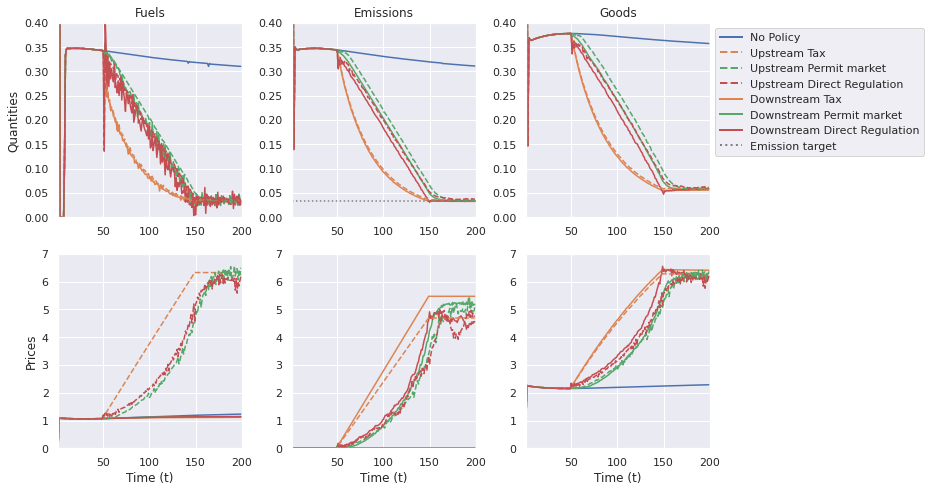

In [5]:
def plot_aggregate_vars(results,ylim1,ylim2):
    
    sns.set()
    
    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(13, 7))
    
    sec, p , usec = results[0]
    
    start = 1
    end = p.T
    ts = range(start,end)
    colors = ["C0","C1","C2","C3","C4","C5","C6"]
    
    for i,sc in enumerate(results):
        
        sec, p , usec = sc   
        
        if p.regpoint == 'upstream': linestyle = "--"
        else: linestyle = "-" 
        if p.mode == "Tax": color = "C1"
        elif p.mode == "Permits": color = "C2"
        elif p.mode == "Direct_Regulation": color = "C3"
        else: color = "C0"
        
        ax1.plot(ts,[sum([j.qg[t] for j in usec]) for t in ts],color=color,linestyle=linestyle,label="Fuel Production")     
        ax2.plot(ts,[sec.E[t] for t in ts],color=color,linestyle=linestyle) 
        ax3.plot(ts,[sum([j.qg[t] for j in sec]) for t in ts],color=color,linestyle=linestyle,label="Goods Production")   
        ax4.plot(ts,[usec.p[t] for t in ts],color=color,linestyle=linestyle,label="Fuel Price")  
        ax5.plot(ts,[p.reg.pe[t] for t in ts],color=color,linestyle=linestyle,label="Permit Price")
        ax6.plot(ts,[sec.p[t] for t in ts],color=color,linestyle=linestyle,label="Goods Price")   
    
    ax1.set_title('Fuels')
    ax2.set_title('Emissions')
    ax3.set_title('Goods')
    
    ax1.set_ylabel('Quantities')
    ax4.set_ylabel('Prices')
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.set_xticks(ts,minor = True)
        ax.set_xlim([start,end])
        
        if ax in [ax1,ax2,ax3]: ax.set_ylim([0,ylim1])
        else: ax.set_ylim([0,ylim2])

    ax2.axhline(p.E_down_target,color='grey',ls=':',label='Abatement Target') # Abatement Target Line        
    
    ax4.set_xlabel('Time (t)')
    ax5.set_xlabel('Time (t)')
    ax6.set_xlabel('Time (t)')
    
    ax3.legend(custom_lines+target_line,custom_labels+['Emission target'],loc='upper left',bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    fig.savefig('Outputs/aggr_vars.pdf')

# Plot Price & Volume Dynamics
if analyze_single_run:
    plot_aggregate_vars(results,0.4,7)

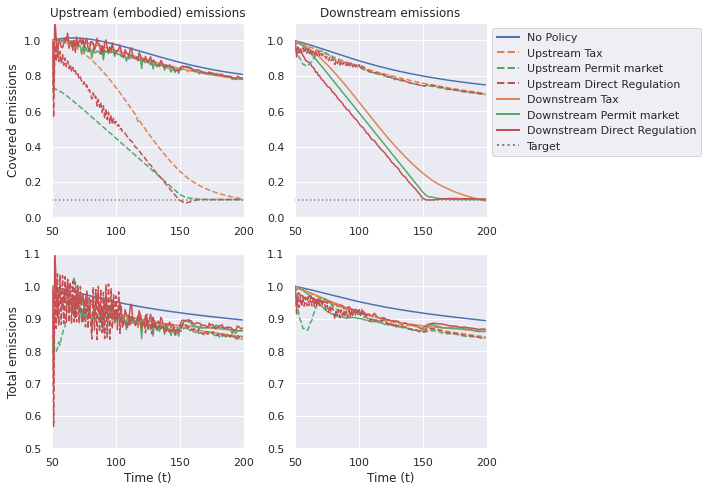

In [6]:
def plot_emissions(results,y1,y2,y3,y4):

    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
    
    sec, p , usec = results[0]

    start = 49 #49
    end = p.T
    trange=range(end-start)
    ts = range(start,end)
    
    for i,sc in enumerate(results):
        
        sec, p , usec = sc   

        if p.regpoint == 'upstream': linestyle = "--"
        else: linestyle = "-" 
        if p.mode == "Tax": color = "C1"
        elif p.mode == "Permits": color = "C2"
        elif p.mode == "Direct_Regulation": color = "C3"
        else: color = "C0"
        
        ax1.plot(ts,[usec.E_cov[t] / usec.E_cov[start] for t in ts],color=color,linestyle=linestyle) 
        ax2.plot(ts,[sec.E_cov[t] / sec.E_cov[start] for t in ts],color=color,linestyle=linestyle)
        
        ax3.plot(ts,[usec.E[t] / usec.E[start] for t in ts],color=color,linestyle=linestyle)
        ax4.plot(ts,[sec.E[t] / sec.E[start] for t in ts],color=color,linestyle=linestyle) 
    
    ax2.set_title('Downstream emissions')
    ax1.set_title('Upstream (embodied) emissions')
    
    ax1.set_ylabel('Covered emissions')
    ax3.set_ylabel('Total emissions')
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_xticks(trange,minor = True)
        ax.set_xlim([start,end])
    
    ax1.axhline(p.E_max,color='grey',ls=':',label='Abatement Target') # Abatement Target Line up_target
    ax2.axhline(p.E_max,color='grey',ls=':',label='Abatement Target') # Abatement Target Line _down_target
    
    ax1.set_ylim(y1,y2)
    ax2.set_ylim(y1,y2)
    ax3.set_ylim(y3,y4)
    ax4.set_ylim(y3,y4)
    
    ax4.set_xlabel('Time (t)')
    ax3.set_xlabel('Time (t)')
    
    ax2.legend(custom_lines+target_line,custom_labels+['Target'],loc='upper left',bbox_to_anchor=(1, 1))

    plt.tight_layout()
    fig.savefig('Outputs/emissions_open.pdf')
    
# Plot Emissions
if analyze_single_run and open_economy:
    plot_emissions(results_open,0,1.1,0.5,1.1) #0.7,1.05)

In [7]:
# Abatement exhaustion
if single_run_details:
    sec,p,usec = results[1]
    print(f'Left abatement options (d_permits,closed) {[len(j.λ) for j in sec]}')

    if open_economy:
        sec,p,usec = results_open[2]
        print(f'Left abatement options (d_permits,open) {[len(j.λ) for j in sec]}')

In [8]:
def plot_abatement_analysis(results, domestic=False):

    sec,p,usec=results[0]

    t0= p.t_start-1 
    T = p.T 
    ts = range (T-t0)
    
    fig, ([[ax0,ax2,ax1],[ax3,ax5,ax4],[ax7,ax8,ax9]]) = plt.subplots(nrows=3, ncols=3, figsize=(11, 7.5))
    axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax7]
    
    label = "Abatement ($α$)"
    if domestic: label = "Local " + label
        
    ax0.set_ylabel(label, fontsize = fs) 
    ax3.set_ylabel(label, fontsize = fs) 
    
    i=0 # Skip no policy
    for sc in results:
        
        sec,p,usec=sc
        
        axs[i].set_title(p.label, fontsize = fs)

        if domestic: ab_21, ab_1,ab_22,ab_tot = calc_local_abatement_analysis(sc,t0)
        else: ab_21, ab_1,ab_22,ab_tot = calc_abatement_analysis(sc,t0)

        pal = ["#bc5090","#ffa600", "#58508d", "#003f5c"] 
        stacks = axs[i].stackplot(ts, ab_21, ab_1,ab_22,  labels=["Compositional change","Technology adoption","Reduction of production"], alpha=0.8, colors=pal) # range(t0,p.T)
        axs[i].axhline(sec.E_cov[t0]-p.reg.E_max,color='grey',ls='--',label='Abatement Target') # Abatement Target Line
        axs[i].plot(ts,ab_tot,label="Total Abatement")
        axs[i].set_xlabel('Time (t)', fontsize = fs)
        axs[i].grid()
        axs[i].set_xlim([0,T-t0])
        axs[i].set_ylim([0,0.7])

        i+=1

    ax0.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Outputs/abatement.pdf')

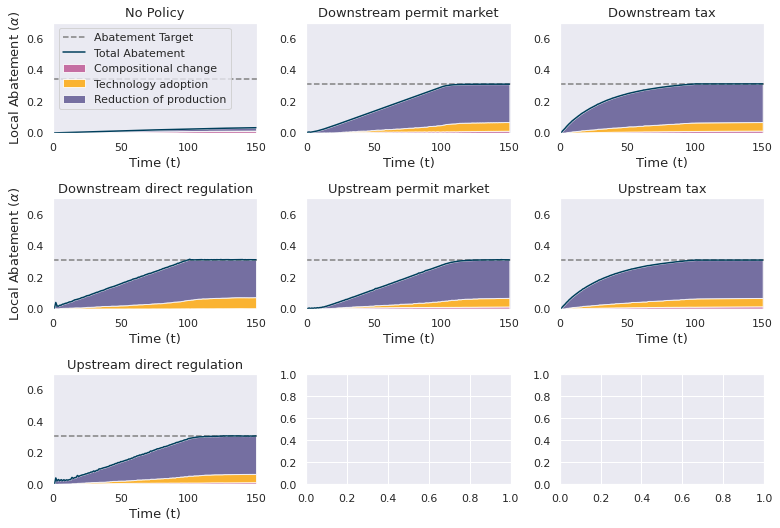

In [9]:
# Plot Abatement Decomposition 
if analyze_single_run:
    plot_abatement_analysis(results,domestic=True) 
    plt.show()

In [10]:
## Detailled Analysis ##
def fplot(variable,label,ax,sec,p):
    
    start = 1
    end = p.T
    ts = range(start,end) 

    for i in range(len(sec)):
        ax.plot(ts,[ getattr(sec[i],variable)[t] for t in ts], label=f'Producer {sec[i].j}') 

    ax.set_xlabel('time (t)')
    ax.set_ylabel(label)
    ax.set_xticks(np.arange(start,end, 1),minor = True)
    ax.grid()
    
def plot_main_dynamics(sec,usec,p):

    fig, ((ax1, ax2,ax3,ax4), (ax5,ax6,ax7,ax8), (ax9,ax10,ax11,ax12)) = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

    fplot("qg","Fuel Production (qg f)",ax1,usec,p)
    
    if p.regpoint == 'upstream': 
        fplot("qp_d","Upstream Desired permits",ax6,usec,p)
    elif p.regpoint == 'downstream': 
        fplot("qp_d","Downstream Desired permits",ax6,sec,p)
 
    fplot("pe","U Emission price",ax7,usec,p)
    fplot("B","U Production costs (B)",ax2,usec,p)
    fplot("Dl","D Unfilled Demand",ax3,sec,p)
    fplot("qg","Goods Production (qg)",ax4,sec,p)
    fplot("pg","Fuel Sales Price (pg f)",ax5,usec,p)

    fplot("pg","Goods Sales Price",ax8,sec,p) 
    fplot("s","Supplier Market-share (s f)",ax9,usec,p)
    fplot("m","m",ax10,usec,p)
    fplot("A","Emission Intensity (A))",ax11,sec,p)
    fplot("s","Producer Market-share (f)",ax12,sec,p)

    plt.tight_layout()

if single_run_details == True:
    for i in [1,2,3,4,5,6]: 
        sec, p , usec = results_open[i]
        print("Scenario ",i)
        print(p.label)
        plot_main_dynamics(sec,usec,p)
        plt.show()

In [11]:
## Plot Tables of Variables over Time ##

def plot_tables(sec,p,start,end):

    for j in range(5):
        f = sec[j]
        m = [["D"]+list(f.D),["A"]+list(f.A),["MAC"]+list(f.MAC),
             ["q_max"]+list(f.q_max),["qg_d"]+list(f.qg_d),
             ["qg_i"]+list(f.qg_i),["qg_s"]+list(f.qg_s),
             ["qg"]+list(f.qg),["pf"]+list(f.pf),["qp_d"]+list(f.qp_d),
             ["u_t"]+list(f.u_t),["u_i"]+list(f.u_i),
             ["pg"]+list(f.pg),["pe"]+list(f.pe),["m"]+list(f.m)]
        m2 = [[i[0]]+i[start+1:end] for i in m]
        headers =  ["FIRM "+str(j)]+list(range(start,end))
        table = tabulate(m2, headers, floatfmt=".6f")
        print(table)
        print("\n")    

if single_run_details == True:
    sec,p,usec = results[3] # Choose Scenario
    start,end = [45,55] # Choose table time-span
    plot_tables(usec,p,start,end) # Choose sec or usec